# Оглавление
<a id="main"></a>

1. [Импорт и просмотр данных](#import)
2. [Преобразование JSON в столбцы](#transform_json)
3. [Получение характеристик](#get_features)
4. [Просмотр признаков с одним значением](#one_feature_view)
5. [Удаление признаков с одним значением](#remove_features)
6. [Просмотр корреляции между признаками](#corr)
6. [Удаление признака, у которого большая корреляция](#remove_corr)

8. Отбор нерасчётных признаков.
9. Отбор расчётных признаков.
10. Кодирование категориальных признаков.
11. Отбор признаков.
12. Обучение моделей.
13. Оценка качества моделей.

### Импорт и просмотр данных
<a id="import"></a>

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('data/train.csv', dtype={'fullVisitorId' : str, 'visitId' : str})

In [3]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  object
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 82.7+ MB


,date,visitNumber,visitStartTime
count,9.036530e+05,903653.000000,9.036530e+05
mean,2.016589e+07,2.264897,1.485007e+09
std,4.697698e+03,9.283735,9.022124e+06
min,2.016080e+07,1.000000,1.470035e+09
25%,2.016103e+07,1.000000,1.477561e+09
50%,2.017011e+07,1.000000,1.483949e+09
75%,2.017042e+07,1.000000,1.492759e+09
max,2.017080e+07,395.000000,1.501657e+09


In [4]:
train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


### Преобразование JSON в столбцы
<a id="transform_json"></a>

In [5]:
train.date = pd.to_datetime(train.date, format='%Y%m%d')
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
train = pd.merge(left=train, right=pd.json_normalize(train.device.apply(json.loads)), 
                 left_index=True, right_index=True).drop('device', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.geoNetwork.apply(json.loads)), 
                 left_index=True, right_index=True).drop('geoNetwork', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.totals.apply(json.loads)), 
                 left_index=True, right_index=True).drop('totals', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.trafficSource.apply(json.loads)), 
                 left_index=True, right_index=True).drop('trafficSource', axis=1)

### Получение количественных, булевых и временных характеристик
<a id="get_features"></a>

In [6]:
train.isTrueDirect = train.isTrueDirect.fillna(False)
train.hits = train.hits.astype(int)
train.visits = train.visits.astype(int)
train.pageviews = train.pageviews.fillna(train.pageviews.astype(float).mean()).astype(int)
train.newVisits = train.newVisits.fillna(0).astype(int)
train.bounces = train.bounces.fillna(0).astype(int)
train.transactionRevenue = train.transactionRevenue.fillna(0).astype(float)
train['adwordsClickInfo.page'] = train['adwordsClickInfo.page'].astype(float)
train['adwordsClickInfo.page'] = train['adwordsClickInfo.page'].fillna(train['adwordsClickInfo.page'].mean())
train['adwordsClickInfo.slot'] = train['adwordsClickInfo.slot'].fillna('unknown')
train['adwordsClickInfo.slot'] = train['adwordsClickInfo.slot'].astype('category')

### Просмотр признаков с одним значением
<a id="one_feature_view"></a>

In [7]:
for c in train:
    if train[c].nunique() <= 1:
        print(c, train[c].nunique())

socialEngagementType 1
browserVersion 1
browserSize 1
operatingSystemVersion 1
mobileDeviceBranding 1
mobileDeviceModel 1
mobileInputSelector 1
mobileDeviceInfo 1
mobileDeviceMarketingName 1
flashVersion 1
language 1
screenColors 1
screenResolution 1
cityId 1
latitude 1
longitude 1
networkLocation 1
visits 1
adwordsClickInfo.criteriaParameters 1
adwordsClickInfo.isVideoAd 1
campaignCode 1


### Удаление столбцов с одним значением
<a id="remove_features"></a>

In [8]:
for c in train:
    if train[c].nunique() == 1:
        train = train.drop(c, axis=1)

### Просмотр корреляции между признаками
<a id="corr"></a>

In [9]:
corr_matrix = train.drop(set(train.select_dtypes(include=['object', 'bool']).columns) , axis=1).corr()

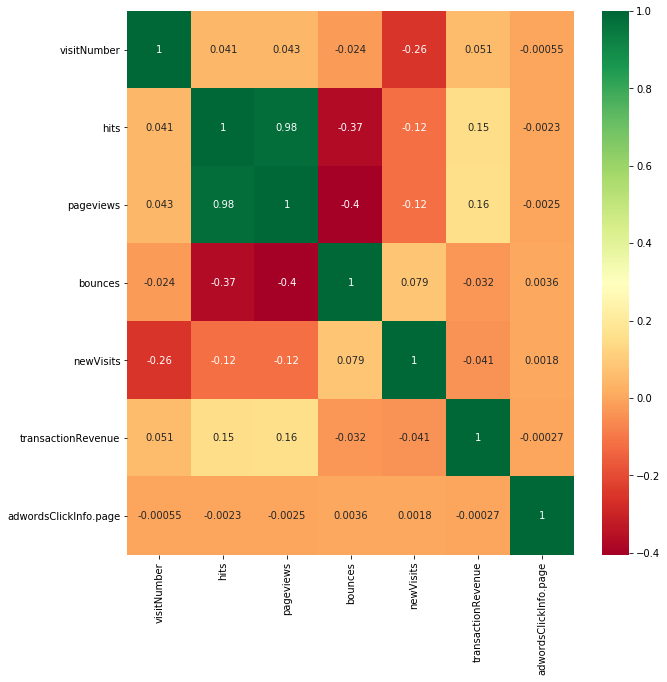

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True,cmap="RdYlGn")

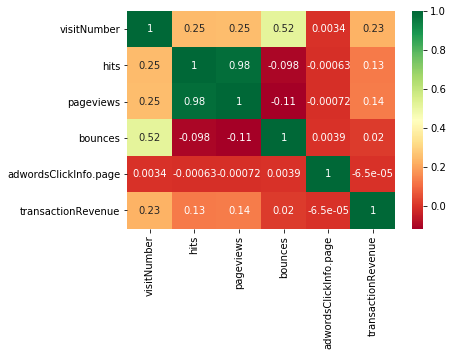

In [11]:
sns.heatmap(train.groupby('fullVisitorId').agg({'visitNumber' : 'max', 'hits' : 'max', 
                                    'pageviews' : 'max', 'bounces' : 'sum', 
                                    'adwordsClickInfo.page' : 'max',
                                               'transactionRevenue' : 'sum'}).corr(), annot=True,cmap="RdYlGn")

### Удаление признака, у которого большая корреляция с другим признаком
<a id="remove_corr"></a>

In [12]:
train = train.drop('pageviews', axis=1)

### Анализ текстовых признаков

In [13]:
train.source.value_counts()

google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                                              16411
                                                      ...  
lmgtfy.com                                                1
oscar.corp.google.com                                     1
cases2.corp.google.com                                    1
news.ycombinator.com                                      1
0.shared.bow.cat2.ads-bow.qk.borg.google.com:9848         1
Name: source, Length: 380, dtype: int64

In [14]:
train.adContent.value_counts()

Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
Google Merchandise                               87
First Full Auto Template Test Ad                 87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

In [15]:
train['adwordsClickInfo.adNetworkType'].value_counts()

Google Search      21453
Search partners        7
Name: adwordsClickInfo.adNetworkType, dtype: int64

In [16]:
train.referralPath.value_counts()

/                                                                       75523
/yt/about/                                                              71036
/analytics/web/                                                         14620
/yt/about/tr/                                                           14599
/yt/about/vi/                                                           13753
                                                                        ...  
/a/google.com/nestlabs/-nestlife/lunch-and-learns                           1
/presentation/d/1yyX2DMnr5NaQqckh92Gy-YECS9hZm30cUMl-UUscs6E/present        1
/document/d/1Esl8vF9A8s84CbxK6y_y8jLzsUE_jORsZQ1ic68QAHE/edit               1
/_/chrome/newtab                                                            1
/maps/d/u/2/edit                                                            1
Name: referralPath, Length: 1475, dtype: int64

In [17]:
train.keyword.value_counts()

(not provided)                     366363
6qEhsCssdK0z36ri                    11503
(Remarketing/Content targeting)      2298
1hZbAqLCbjwfgOH7                     2264
google merchandise store             2209
                                    ...  
shtop yuo tobe                          1
youtube shirt buy                       1
google sticker shop                     1
buy t-shirt                             1
is youtube give tshrt                   1
Name: keyword, Length: 3659, dtype: int64

In [18]:
train.campaign.value_counts()

(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: campaign, dtype: int64

In [19]:
train.medium.value_counts()

organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: medium, dtype: int64

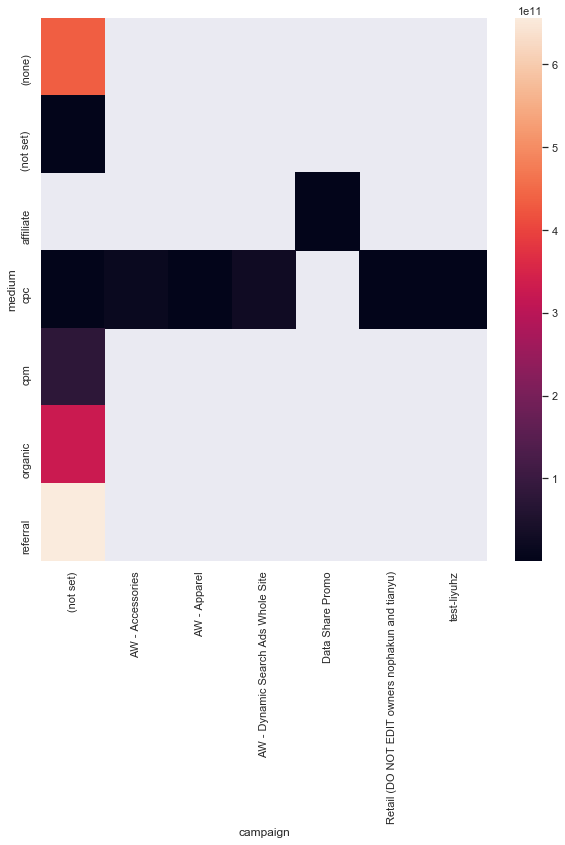

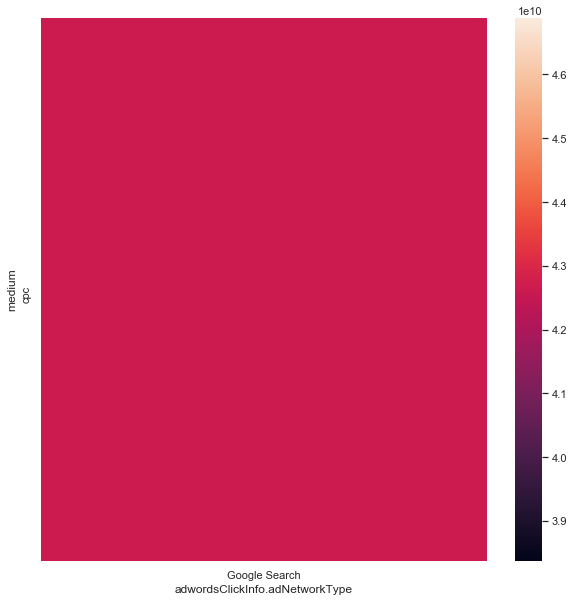

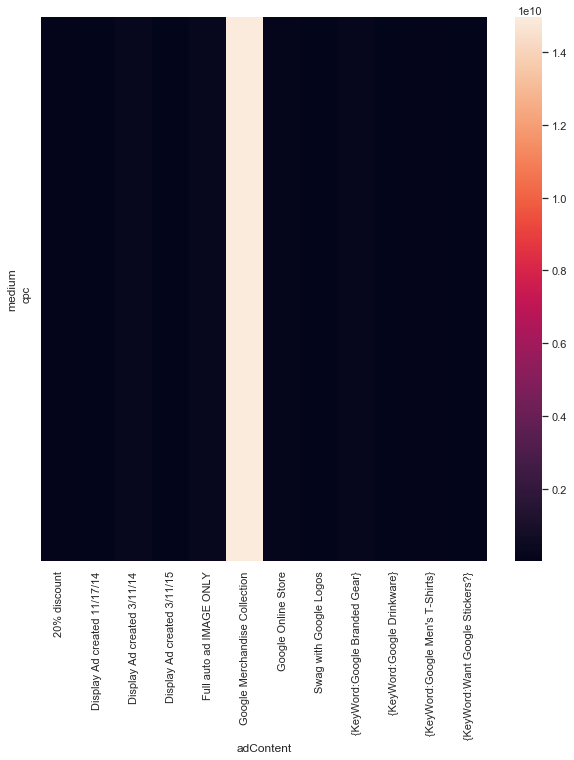

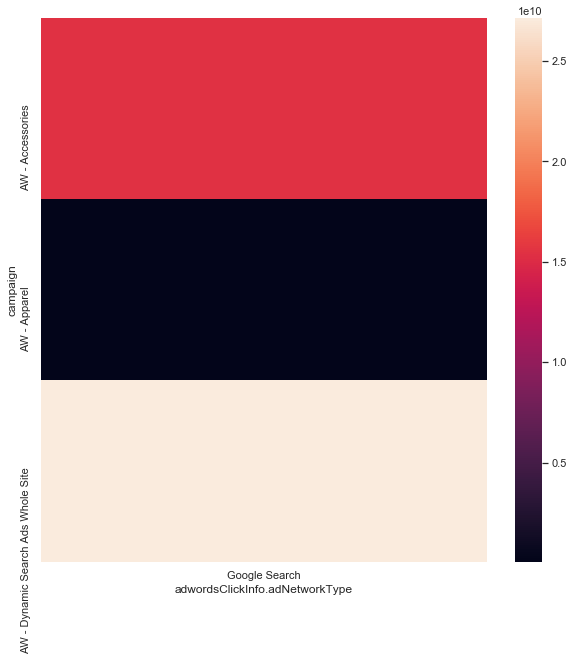

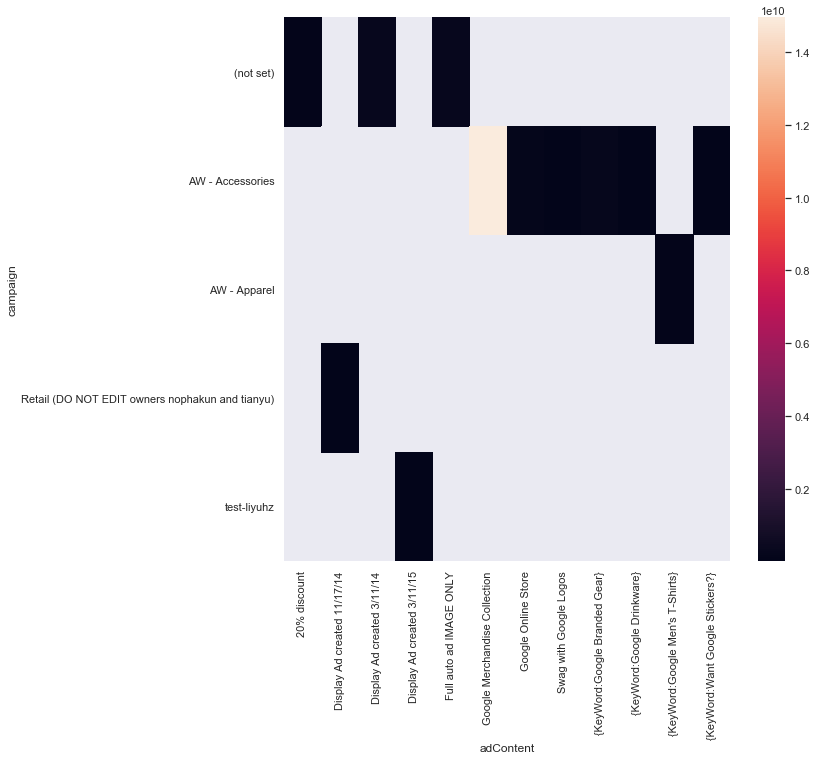

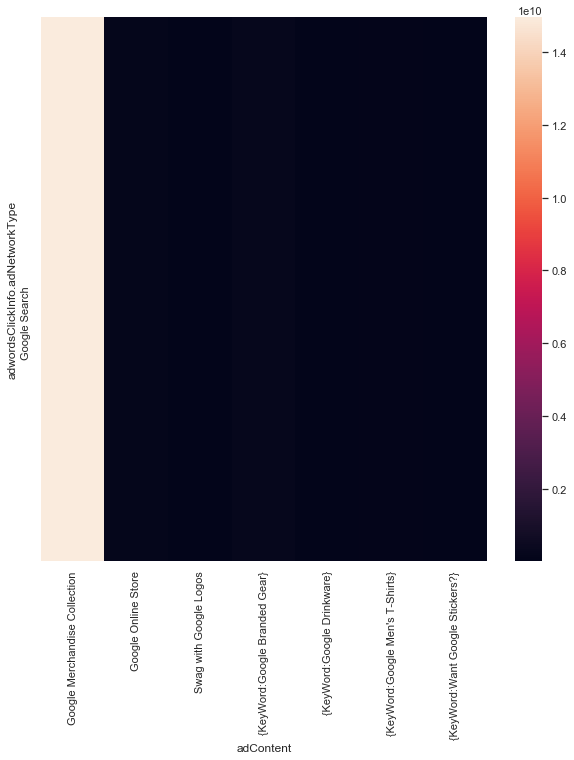

In [20]:
cat_cols = ['medium', 'campaign', 'adwordsClickInfo.adNetworkType', 'adContent']
test = train.groupby('fullVisitorId')
for cat in range(len(cat_cols) - 1):
    for col in range(cat + 1, len(cat_cols)):
        sns.set()
        fig, ax = plt.subplots(figsize=(10,10)) 
        table = train.loc[train.transactionRevenue != 0].pivot_table(
            index=cat_cols[cat], 
            columns=cat_cols[col], 
            values='transactionRevenue', 
            aggfunc=np.sum)
        sns.heatmap(table, fmt=".1f", ax=ax)

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   channelGrouping                 903653 non-null  object        
 1   date                            903653 non-null  datetime64[ns]
 2   fullVisitorId                   903653 non-null  object        
 3   sessionId                       903653 non-null  object        
 4   visitId                         903653 non-null  object        
 5   visitNumber                     903653 non-null  int64         
 6   visitStartTime                  903653 non-null  datetime64[ns]
 7   browser                         903653 non-null  object        
 8   operatingSystem                 903653 non-null  object        
 9   isMobile                        903653 non-null  bool          
 10  deviceCategory                  903653 non-null  object 

<Figure size 432x288 with 0 Axes>

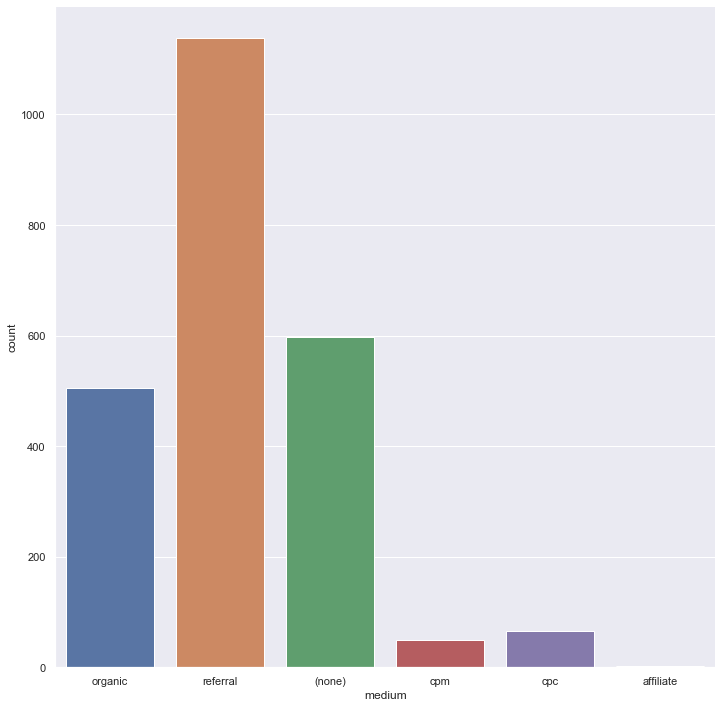

<Figure size 432x288 with 0 Axes>

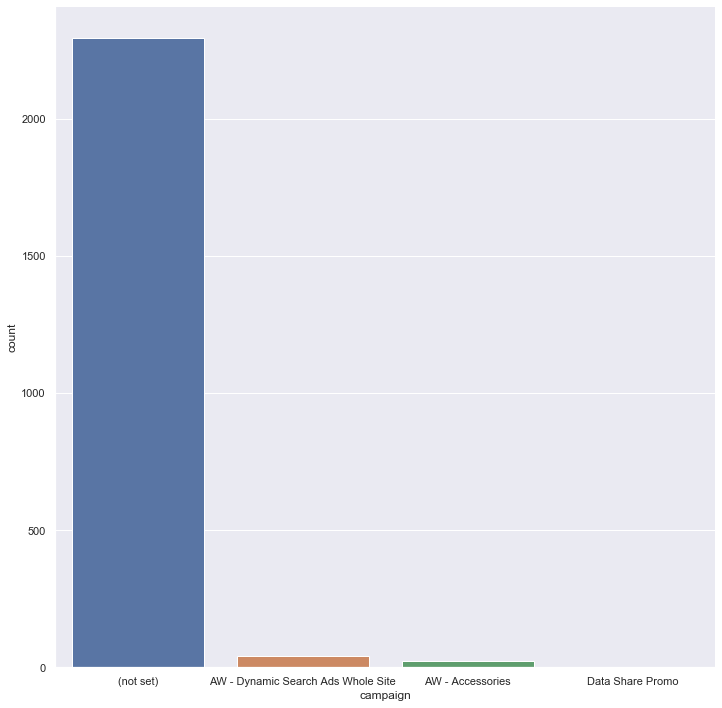

<Figure size 432x288 with 0 Axes>

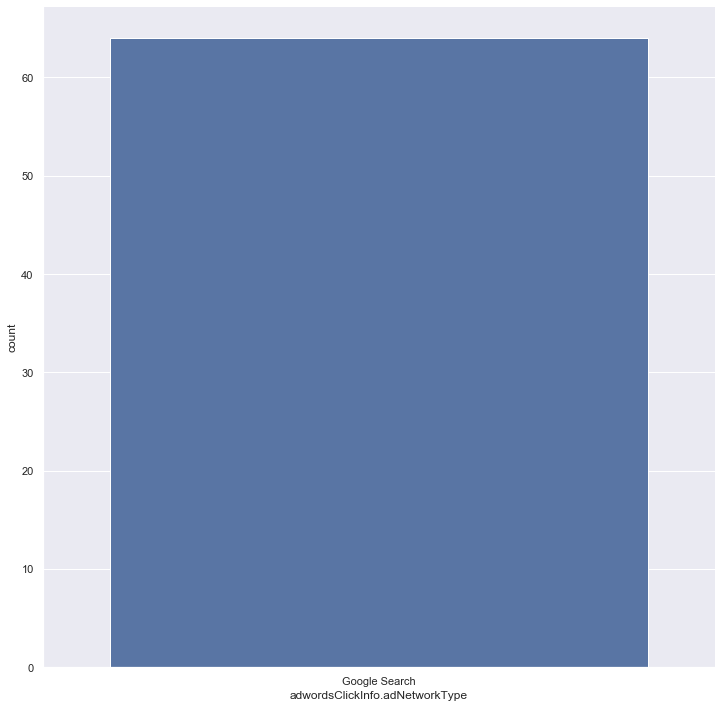

<Figure size 432x288 with 0 Axes>

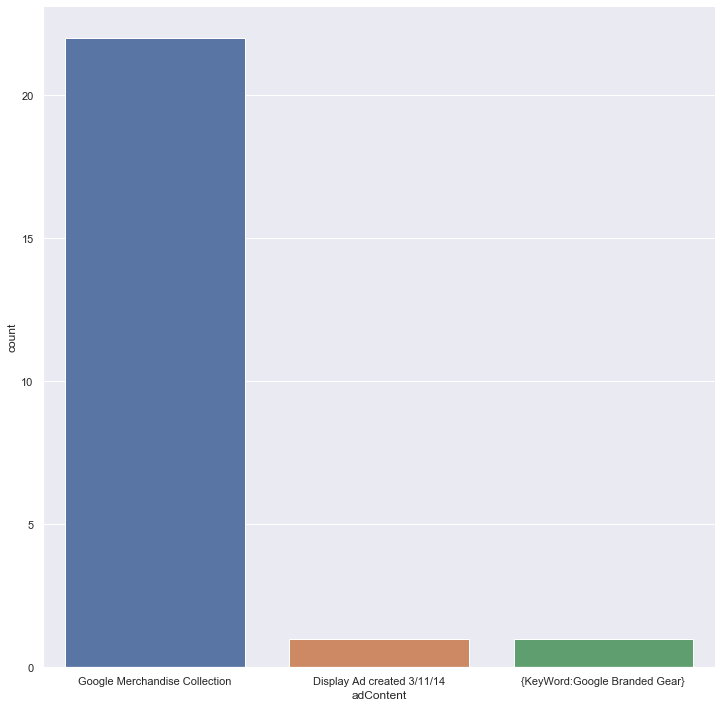

In [22]:
cat_cols = ['medium', 'campaign', 'adwordsClickInfo.adNetworkType', 'adContent']
t = train.loc[train.transactionRevenue != 0]
for col in cat_cols:
    sns.set()
    plt.figure()
    sns.catplot(x=col, kind='count', data=t.loc[t.transactionRevenue > t.transactionRevenue.mean()], height=10)
    plt.show()

<Figure size 432x288 with 0 Axes>

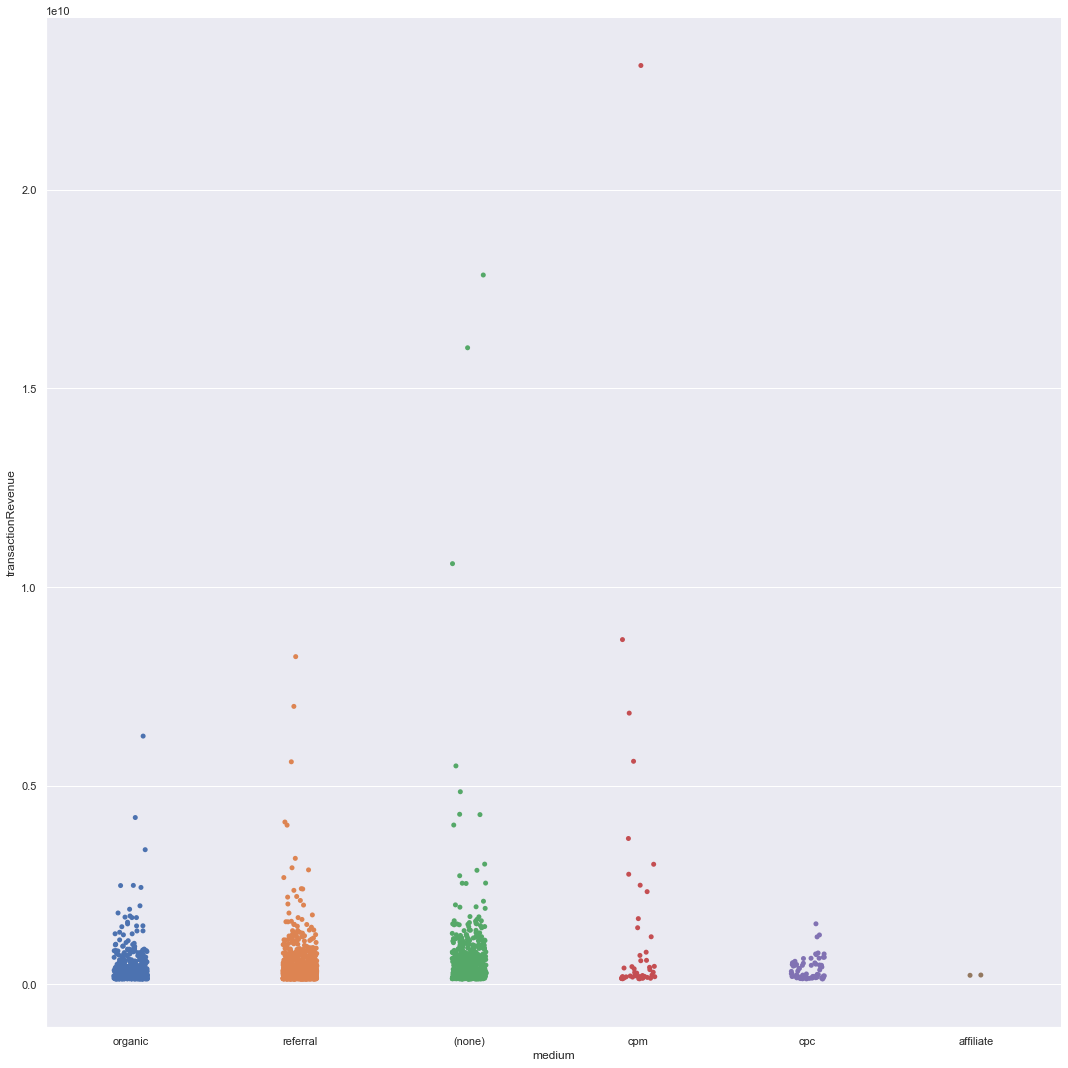

<Figure size 432x288 with 0 Axes>

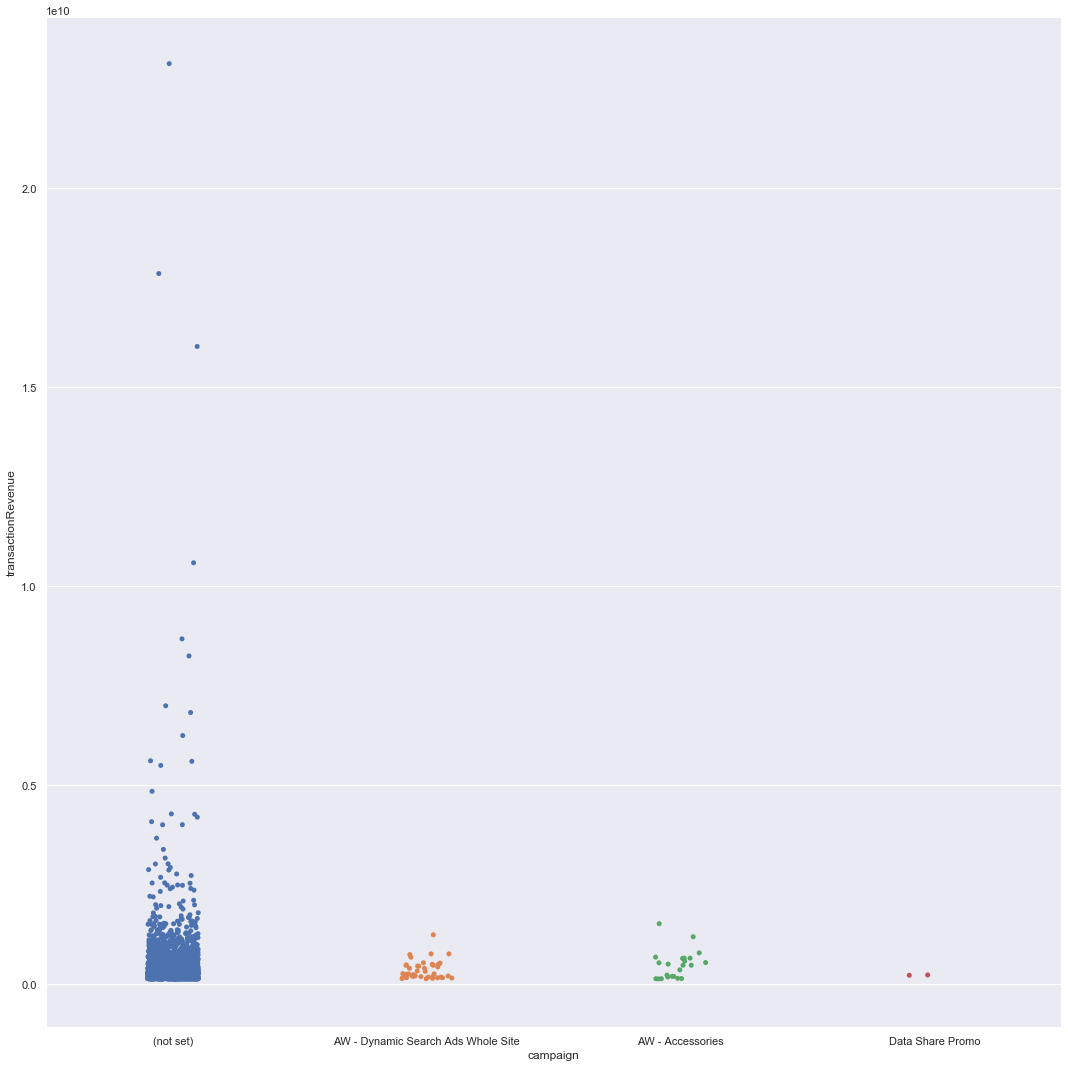

<Figure size 432x288 with 0 Axes>

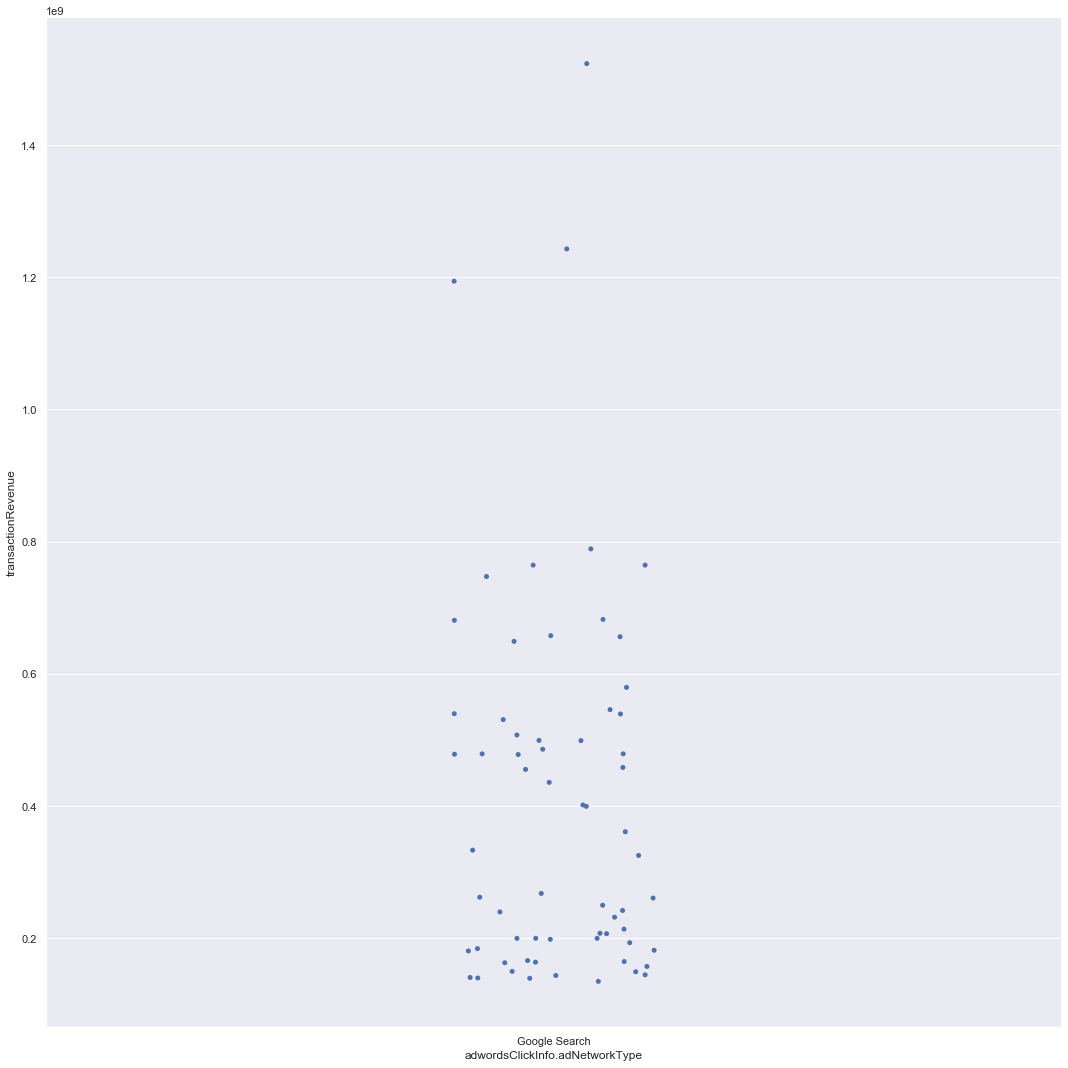

<Figure size 432x288 with 0 Axes>

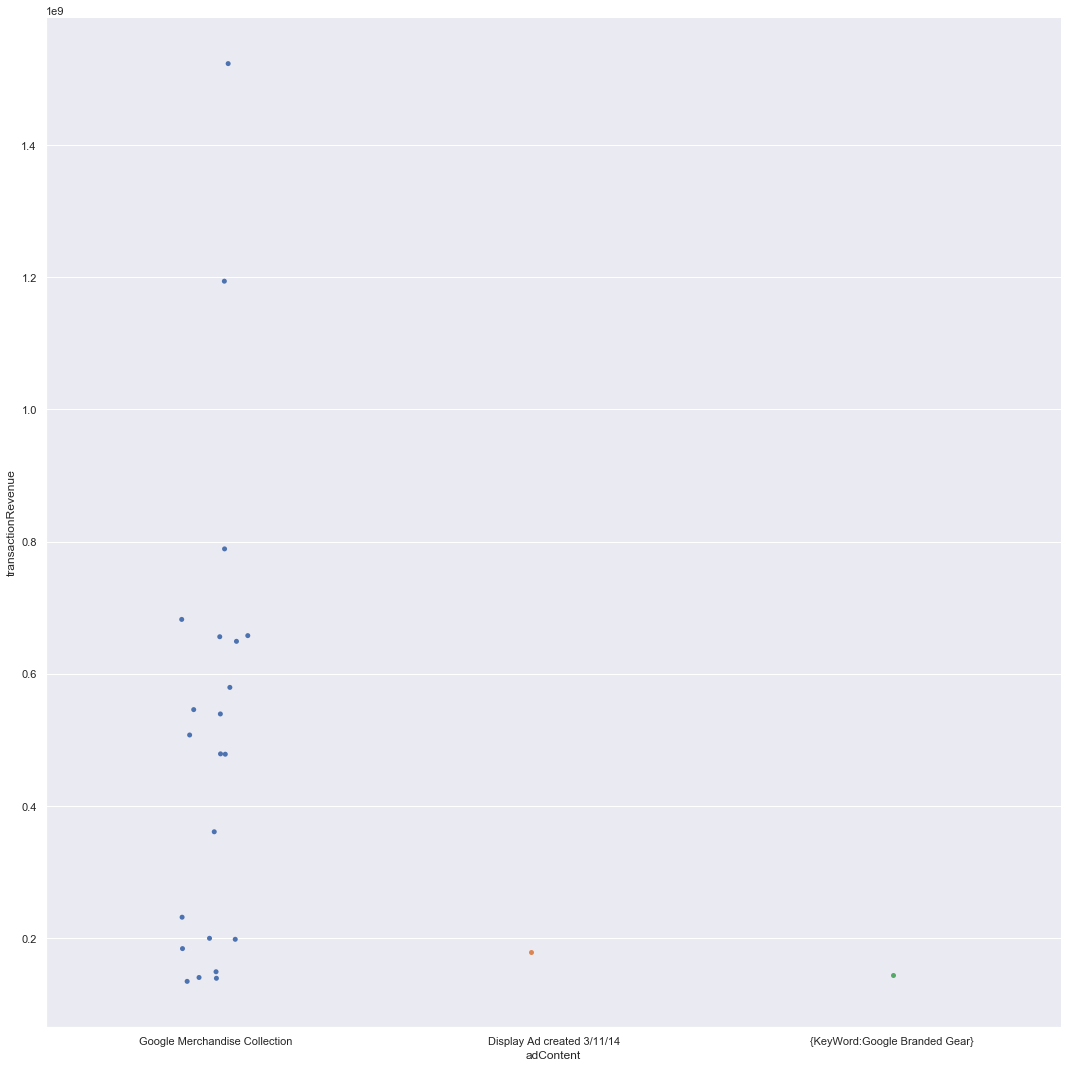

In [23]:
cat_cols = ['medium', 'campaign', 'adwordsClickInfo.adNetworkType', 'adContent']
t = train.loc[train.transactionRevenue != 0]
for col in cat_cols:
    sns.set()
    plt.figure()
    sns.catplot(x=col, y="transactionRevenue", data=t.loc[t.transactionRevenue > t.transactionRevenue.mean()], height=15)
    plt.show()

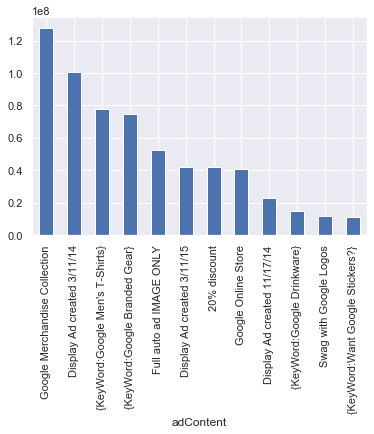

In [24]:
train.loc[train.transactionRevenue != 0].groupby('adContent').transactionRevenue.mean().sort_values(ascending=False).plot(kind='bar')

In [25]:
import re

def replace_company(serie, old, new=None):
    if new is None:
        new = old
    serie = serie.str.lower()
    regex_exp = re.compile(r'(\d|\D)*' + old + '(\d|\D)*')
    serie = serie.replace(regex_exp, new)
    return serie

In [26]:
train['typeAd'] = train.adContent
train.typeAd = replace_company(train.typeAd, '(display|image)', 'image')
train.typeAd = replace_company(train.typeAd, 'keyword')
train.typeAd = replace_company(train.typeAd, 'google', 'company')
train.typeAd = replace_company(train.typeAd, 'discount')
train.typeAd = train.typeAd.fillna('unknown')

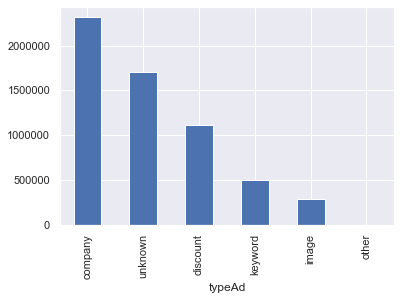

In [27]:
train.loc[~train.typeAd.str.contains('image|keyword|company|discount|unknown'), 'typeAd'] = 'other'
train.groupby('typeAd').transactionRevenue.mean().sort_values(ascending=False).plot(kind='bar')

In [28]:
train.typeAd = train.typeAd.astype('category')

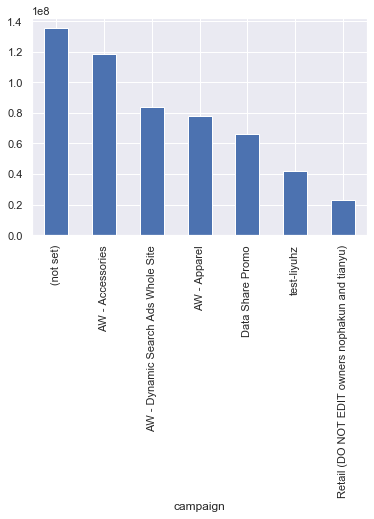

In [29]:
train.loc[train.transactionRevenue != 0].groupby('campaign').transactionRevenue.mean().sort_values(ascending=False).plot(kind='bar')

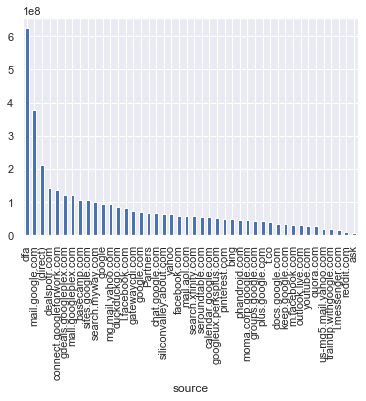

In [30]:
train.loc[train.transactionRevenue != 0].groupby('source').transactionRevenue.mean().sort_values(ascending=False).plot(kind='bar')

In [31]:
train['isDFA'] = list(map(lambda x: True if x == 'dfa' else False, train.source))

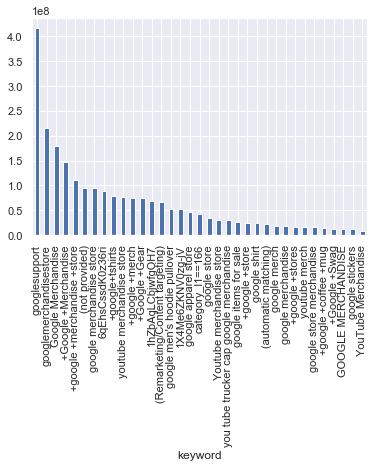

In [32]:
train.loc[train.transactionRevenue != 0].groupby('keyword').transactionRevenue.mean().sort_values(ascending=False).plot(kind='bar')

In [33]:
train['typeSearch'] = train.keyword
train.typeSearch = replace_company(train.typeSearch, '(merch|store|mug|stickers|shirt|sticker|item|pullover|gear)', 'merchandise')

In [34]:
train.typeSearch = replace_company(train.typeSearch, 'support')

In [35]:
train.typeSearch = train.typeSearch.fillna('none')

In [36]:
train.loc[~train.typeSearch.str.contains('merch|store|mug|stickers|shirt|sticker|item|pullover|gear|support|none'), 'typeSearch'] = 'other'

In [37]:
train.typeSearch = train.typeSearch.astype('category')

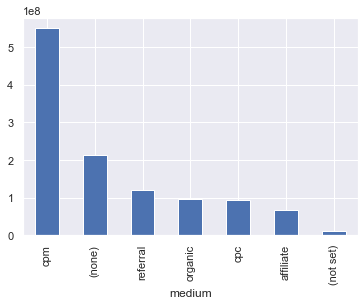

In [38]:
train.loc[train.transactionRevenue != 0].groupby('medium').transactionRevenue.mean().sort_values(ascending=False).plot(kind='bar')

### Получение признака того, искал ли человек или нет

In [39]:
train['isSearched'] = list(map(lambda x: False if x is np.nan else True, train.keyword))

### Просмотр распределения среднего transaction revenue по часам

In [40]:
train['hour'] = train.visitStartTime.dt.hour

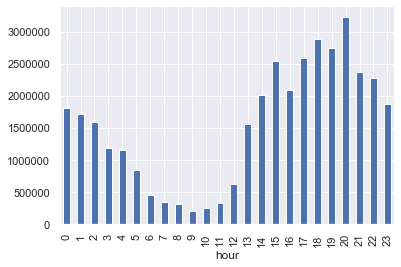

In [41]:
train.groupby('hour').transactionRevenue.mean().plot(kind='bar')

### Кодирование признака часа

In [42]:
hour_dict = dict()
for i in range(5, 13):
    hour_dict[i] = 0
for i in range(13, 21):
    hour_dict[i] = 1
    
hour_dict[0] = 3
hour_dict[1] = 3
hour_dict[2] = 3
hour_dict[3] = 3
hour_dict[4] = 3
hour_dict[22] = 3
hour_dict[23] = 3

In [43]:
train['hour'] = train.hour.map(hour_dict)

### Просмотр распределения среднего transaction revenue по дням недели

In [44]:
train['dayOfWeek'] = train['date'].dt.dayofweek

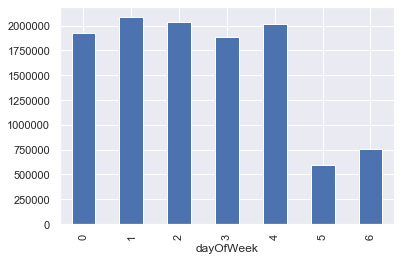

In [45]:
train.groupby('dayOfWeek').transactionRevenue.mean().plot(kind='bar')

Из графика можно увидеть, что на будние дни приходится большое среднее значение покупок, потому имеет смысл закодировать дни недели, как бинарную переменную.

In [46]:
train['isWeekday'] = list(map(lambda x: True if x < 5 else False, train.dayOfWeek))

### Просмотр распределения среднего transaction revenue по месяцам

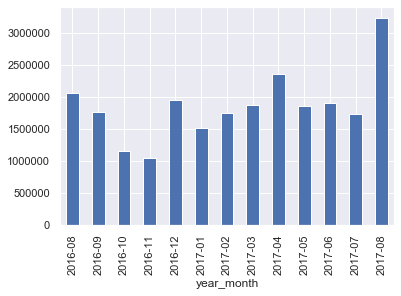

In [48]:
train['year_month'] = train.date.dt.strftime('%Y-%m')
train.groupby('year_month').transactionRevenue.mean().plot(kind='bar')

In [49]:
#train['isForthMonth'] = list(map(lambda x: True if x in ['2016-08', '2016-12', '2017-04', '2017-08'] else False, train.year_month))

In [47]:
train['month'] = train.date.dt.month

In [48]:
train['isForthMonth'] = list(map(lambda x: x / 4, train.month))

In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 42 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   channelGrouping                 903653 non-null  object        
 1   date                            903653 non-null  datetime64[ns]
 2   fullVisitorId                   903653 non-null  object        
 3   sessionId                       903653 non-null  object        
 4   visitId                         903653 non-null  object        
 5   visitNumber                     903653 non-null  int64         
 6   visitStartTime                  903653 non-null  datetime64[ns]
 7   browser                         903653 non-null  object        
 8   operatingSystem                 903653 non-null  object        
 9   isMobile                        903653 non-null  bool          
 10  deviceCategory                  903653 non-null  object 

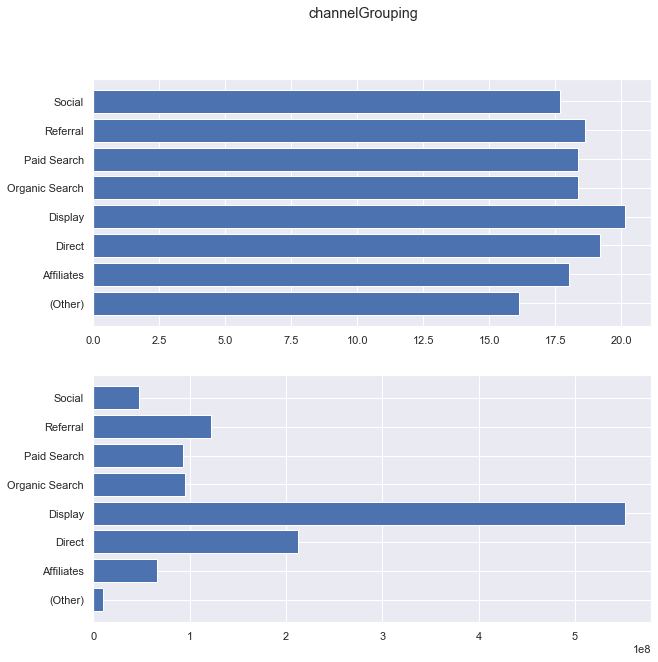

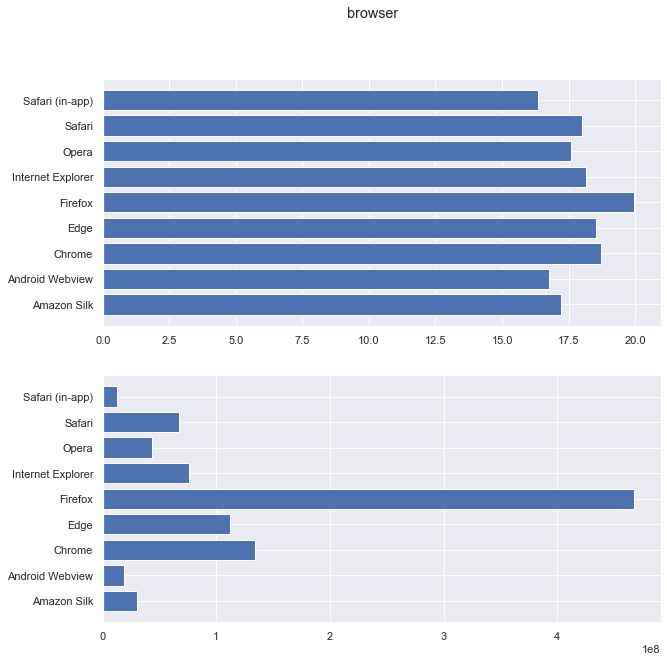

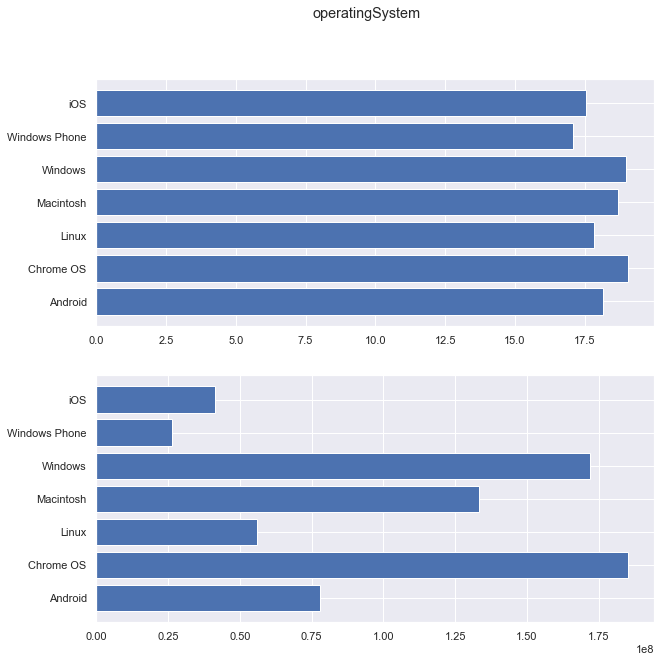

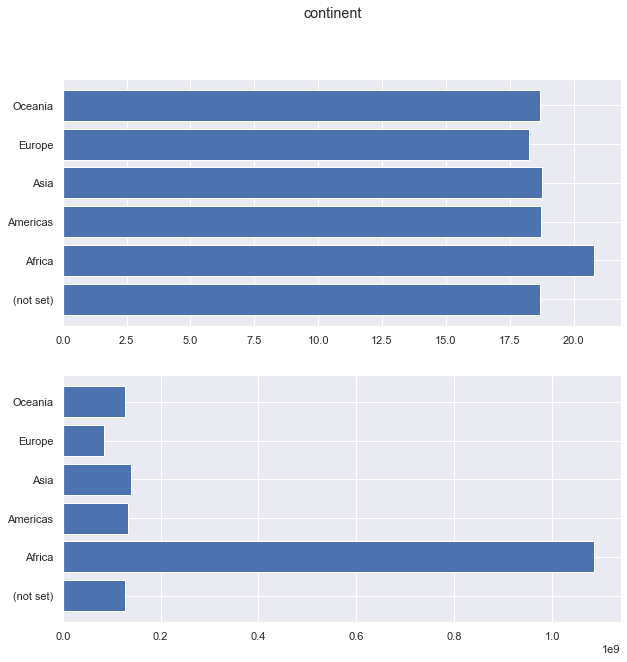

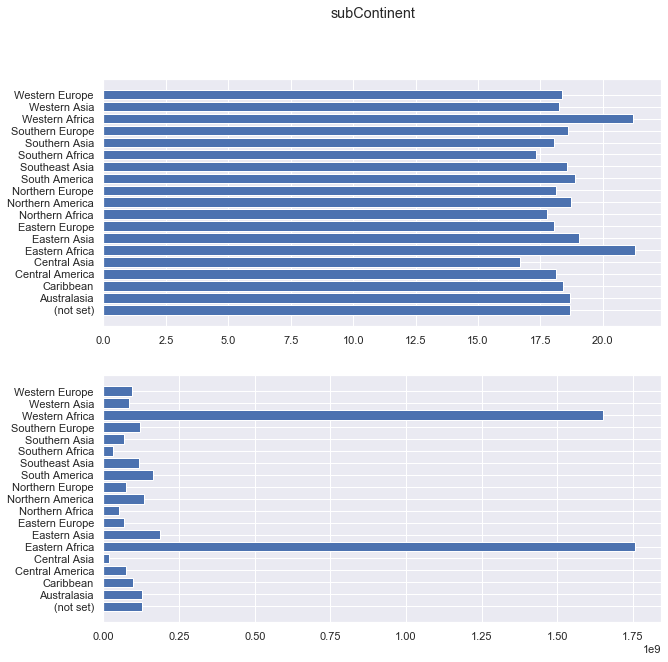

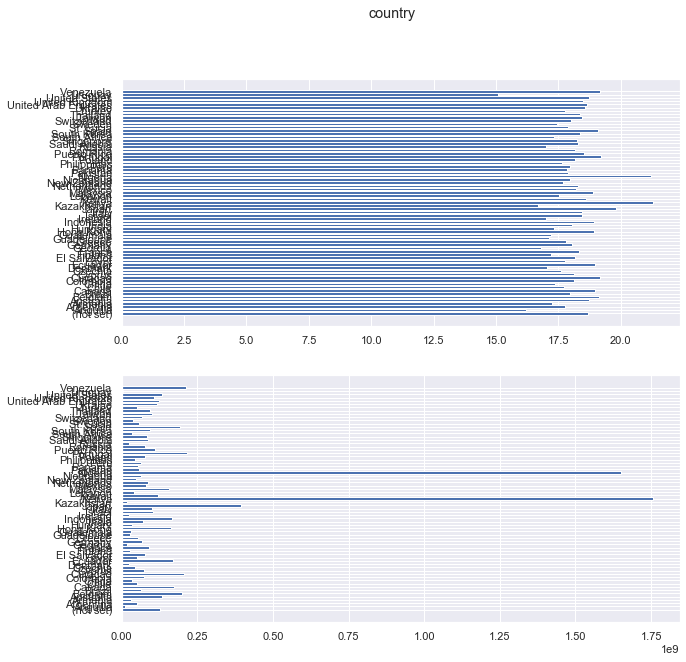

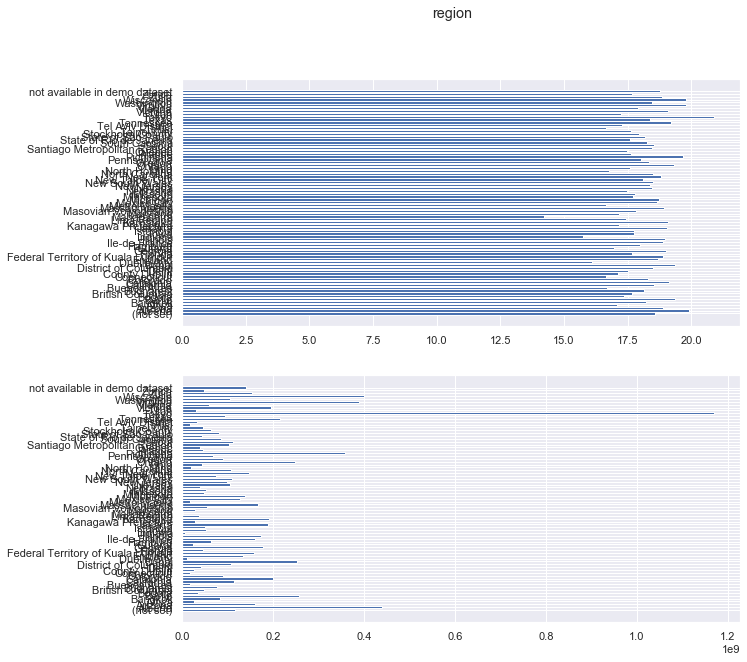

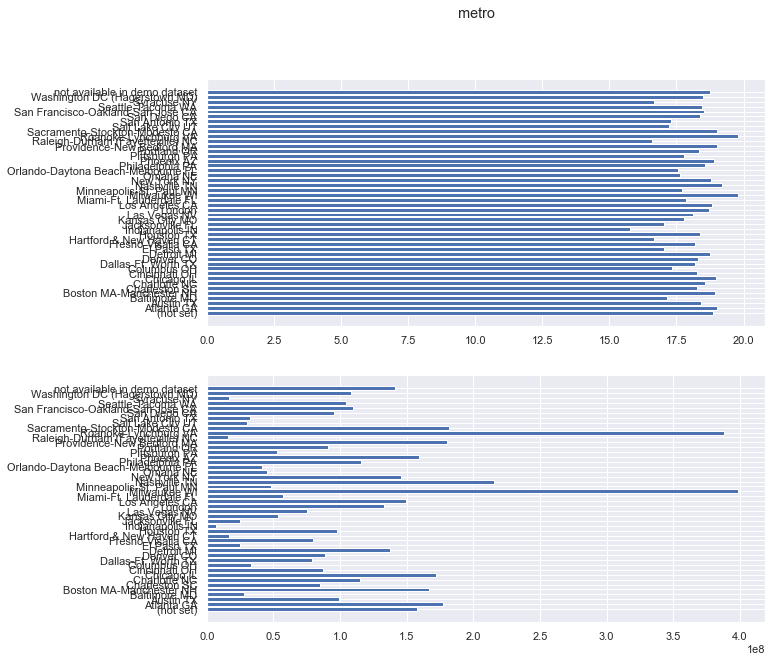

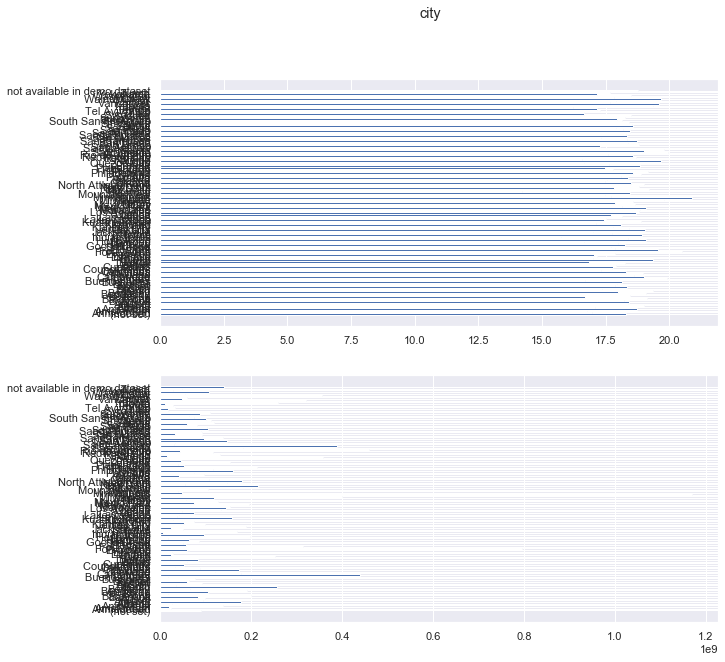

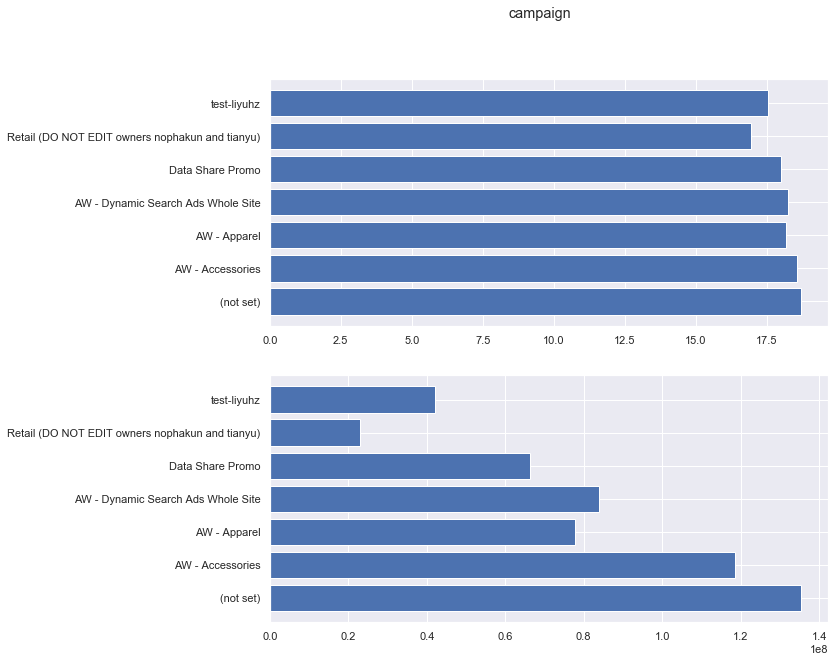

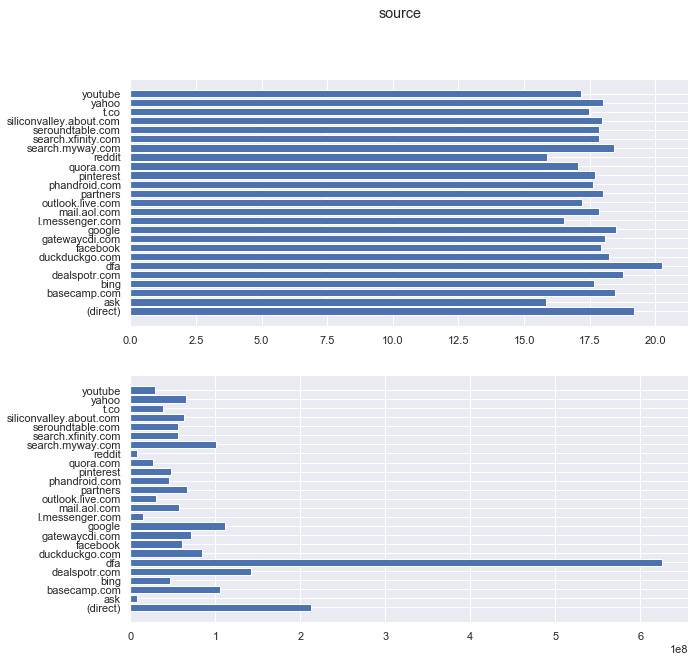

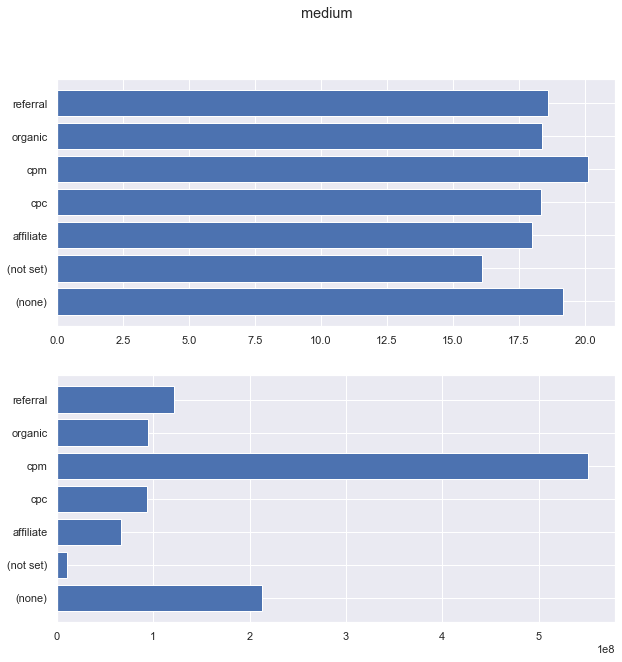

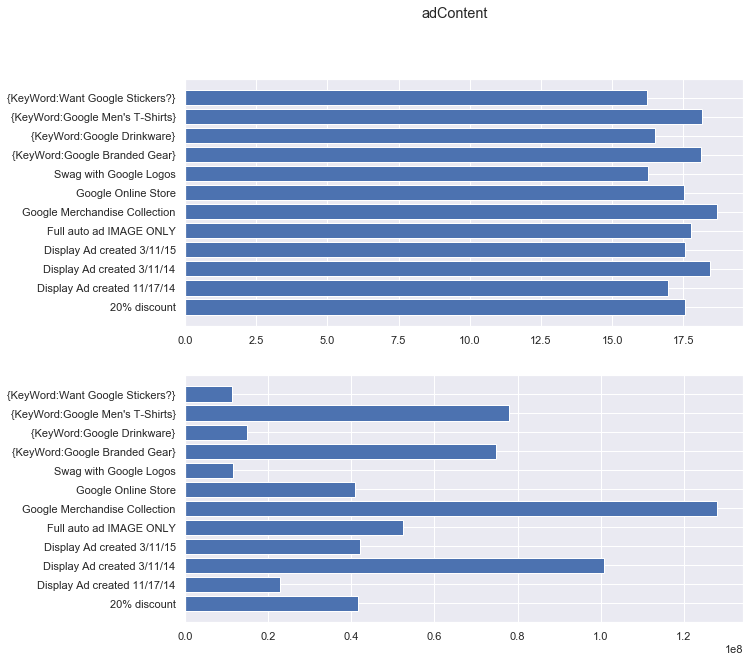

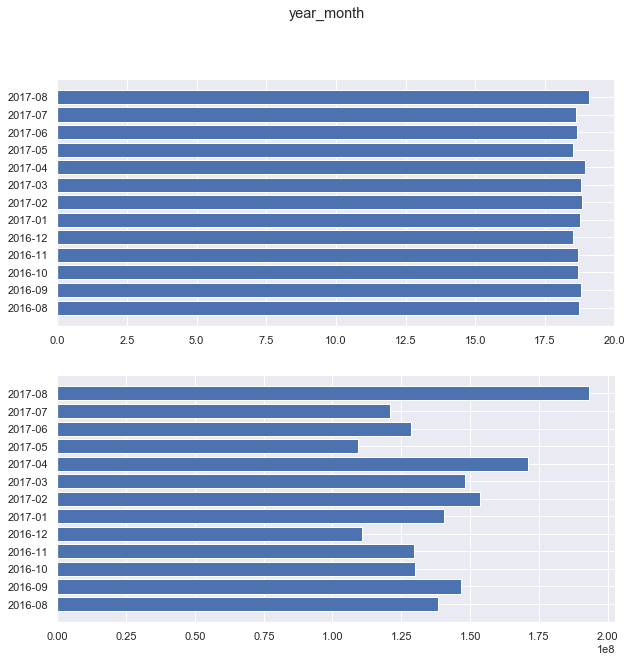

In [51]:
for c in train:
    if 5 <= train[c].nunique() <= 1000 and train[c].dtype == 'object':
        fig, axs = plt.subplots(2, figsize=(10, 10))
        fig.suptitle(c)
        grouped = train.loc[train.transactionRevenue != 0].groupby(c).transactionRevenue.mean().reset_index()
        axs[0].barh(grouped[c], np.log(1 + grouped.transactionRevenue))
        axs[1].barh(grouped[c], grouped.transactionRevenue)
        plt.show()

In [174]:
def get_codes_by_conditions(column, df, conditions):
    df = df.groupby(column).transactionRevenue.sum().reset_index()
    codes = {}
    value = np.log(1 + df.transactionRevenue)
    for c in range(len(conditions) - 1):
        values = df.loc[(conditions[c] <= value) & (value < conditions[c + 1])][column]
        for v in values:
            codes[v] = c
    return codes

In [175]:
def show_subplots(column, df):
    fig, axs = plt.subplots(2, figsize=(10, 10))
    fig.suptitle(column)
    grouped = df.groupby(column).transactionRevenue.sum().reset_index()
    axs[0].barh(grouped[column], np.log(1 + grouped.transactionRevenue))
    axs[1].barh(grouped[column], grouped.transactionRevenue)
    plt.show()

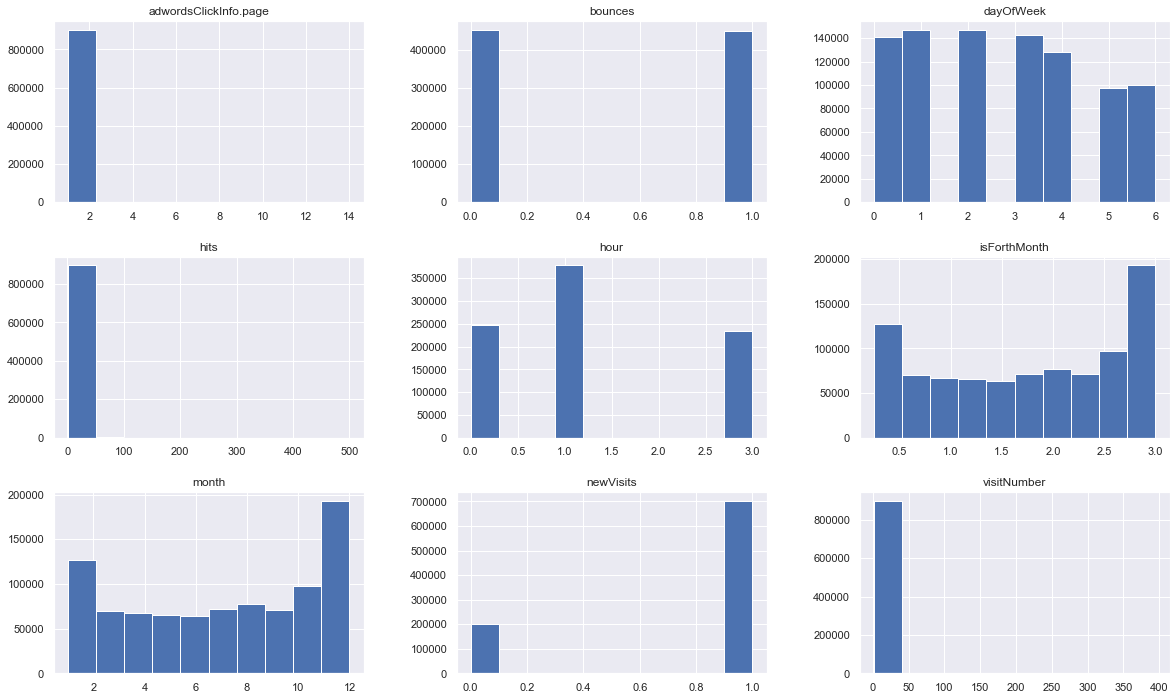

In [50]:
features = list(set(train.select_dtypes(exclude=['object', 'bool']).columns) - set(['transactionRevenue']))
train[features].hist(figsize=(20,12));

In [54]:
train['pattern'] = train['adContent'] + "_" + train['adwordsClickInfo.adNetworkType']

In [55]:
train.pattern = list(map(lambda x: "google" if x == "Google Merchandise Collection_Google Search" else "other", train.pattern))

In [56]:
train.pattern = train.pattern.astype('category')

In [57]:
!pip install mlxtend

Изначальные признаки:
1. visitNumber
2. isMobile
3. hits
4. bounces
5. isTrueDirect
6. adwordsClickInfo.page
7. adwordsClickInfo.slot

Расчётные признаки:
1. isSearched
2. isWeekday
3. isForthMonth
4. adContent

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   channelGrouping                 903653 non-null  object        
 1   date                            903653 non-null  datetime64[ns]
 2   fullVisitorId                   903653 non-null  object        
 3   sessionId                       903653 non-null  object        
 4   visitId                         903653 non-null  object        
 5   visitNumber                     903653 non-null  int64         
 6   visitStartTime                  903653 non-null  datetime64[ns]
 7   browser                         903653 non-null  object        
 8   operatingSystem                 903653 non-null  object        
 9   isMobile                        903653 non-null  bool          
 10  deviceCategory                  903653 non-null  object 

In [60]:
temp = train

In [61]:
train = train.sample(frac=0.1)

In [62]:
features = list(train.select_dtypes(include=['category']).columns)

In [63]:
fs = ['browser', 'operatingSystem', 'deviceCategory', 'continent', 'subContinent', 'country', 'region', 'metro', 'city', 'networkDomain']

In [64]:
features = features + fs

In [65]:
encoder = LabelEncoder()
train[features] = train[features].apply(encoder.fit_transform)

In [66]:
compute_features = ['fullVisitorId', 'isSearched', 'isWeekday', 
                    'isForthMonth', 'typeAd', 'transactionRevenue',
                   'typeSearch', 'isDFA', 'pattern']
source_features = ['fullVisitorId', 'visitNumber', 'isMobile', 
                   'hits', 'bounces', 'isTrueDirect', 'transactionRevenue', 
                   'adwordsClickInfo.page', 'adwordsClickInfo.slot'] + fs

### Отбор признаков из расчётных

In [67]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

def get_selected_features(df, k):
    X = df.drop(['fullVisitorId', 'transactionRevenue'], axis=1)
    y = np.log(df.transactionRevenue + 1)
    selector = SequentialFeatureSelector(LinearRegression(), verbose=2, k_features=k, forward=False, n_jobs=-1)
    selector.fit(X, y)
    selector.subsets_
    return list(selector.subsets_[k]['feature_names'])

In [68]:
df = train[compute_features]

In [69]:
df.columns

Index(['fullVisitorId', 'isSearched', 'isWeekday', 'isForthMonth', 'typeAd',
       'transactionRevenue', 'typeSearch', 'isDFA', 'pattern'],
      dtype='object')

In [70]:
df = df.groupby('fullVisitorId').agg({'isSearched' : 'mean',
                                     'isWeekday' : 'mean',
                                     'isForthMonth' : 'mean',
                                     'typeAd' : 'mean',
                                     'transactionRevenue' : 'sum',
                                     'typeSearch' : 'mean',
                                     'isDFA' : 'mean',
                                     'pattern' : 'max'})

In [ ]:
df = df.groupby('fullVisitorId').agg(isSearched = ('isSearched', lambda x:x.value_counts().index[0]),
                                     isWeekday = ('isWeekday', lambda x:x.value_counts().index[0]),
                                     isForthMonth = ('isForthMonth', lambda x:x.value_counts().index[0]),
                                     typeAd = ('typeAd', 'max'),
                                     transactionRevenue = ('transactionRevenue', 'sum'),
                                     typeSearch = ('typeSearch', 'max'), 
                                     isDFA = ('isDFA', lambda x:x.value_counts().index[0]),
                                    pattern = ('pattern', 'max'))

In [71]:
df = df.reset_index()

In [72]:
cols_computed = get_selected_features(df, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    2.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    2.3s finished

[2020-05-25 23:58:33] Features: 6/5 -- score: 0.0008749554604265963[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.7s finished

[2020-05-25 23:58:33] Features: 5/5 -- score: 0.0008814745896447374

### Отбор признаков из исходных

In [73]:
df = train[source_features]

In [74]:
df.columns

Index(['fullVisitorId', 'visitNumber', 'isMobile', 'hits', 'bounces',
       'isTrueDirect', 'transactionRevenue', 'adwordsClickInfo.page',
       'adwordsClickInfo.slot', 'browser', 'operatingSystem', 'deviceCategory',
       'continent', 'subContinent', 'country', 'region', 'metro', 'city',
       'networkDomain'],
      dtype='object')

In [71]:
df = df.groupby('fullVisitorId').agg({'visitNumber' : 'max',
                                        'isMobile' : 'mean',
                                       'hits': 'mean',
                                       'bounces' : 'mean',
                                       'transactionRevenue' : 'sum',
                                        'isTrueDirect' : 'mean',
                                        'adwordsClickInfo.page' : 'mean',
                                     'adwordsClickInfo.slot' : 'mean'})

In [76]:
df = df.groupby('fullVisitorId').agg({'visitNumber' : 'max',
                                        'isMobile' : 'mean',
                                       'hits': 'mean',
                                       'bounces' : 'mean',
                                       'transactionRevenue' : 'sum',
                                        'isTrueDirect' : 'mean',
                                        'adwordsClickInfo.page' : 'mean',
                                     'adwordsClickInfo.slot' : 'mean',
                                     'browser' : 'mean',
                                     'operatingSystem' : 'mean', 
                                      'deviceCategory' : 'mean',
                                      'continent' : 'mean',
                                      'subContinent' : 'mean',
                                      'country' : 'mean',
                                      'region' : 'mean',
                                      'metro' : 'mean',
                                      'city' : 'mean',
                                      'networkDomain' : 'mean'})

In [73]:
df = df.groupby('fullVisitorId').agg({'visitNumber' : 'max',
                                        'isMobile' : lambda x:x.value_counts().index[0],
                                       'hits': 'max',
                                       'bounces' : 'max',
                                       'transactionRevenue' : 'sum',
                                        'isTrueDirect' : lambda x:x.value_counts().index[0],
                                        'adwordsClickInfo.page' : 'mean',
                                     'adwordsClickInfo.slot' : lambda x:x.value_counts().index[0]})

In [77]:
df = df.reset_index()

In [78]:
cols_source = get_selected_features(df, 5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    3.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    3.6s finished

[2020-05-26 00:00:43] Features: 16/5 -- score: 0.14140529109060512[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed:    2.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    2.7s finished

[2020-05-26 00:00:46] Features: 15/5 -- score: 0.14141342221616643[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.4s finished

[2020-05-26 00:00:49] Features: 14/5 -- score: 0.14141963333294894[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of 

### Объединение по отобранным признакам

In [79]:
df = train[cols_computed + cols_source + ['fullVisitorId', 'transactionRevenue']]

In [80]:
df.columns

Index(['isSearched', 'isWeekday', 'isForthMonth', 'typeSearch', 'pattern',
       'visitNumber', 'isMobile', 'hits', 'isTrueDirect', 'country',
       'fullVisitorId', 'transactionRevenue'],
      dtype='object')

In [81]:
df = df.groupby('fullVisitorId').agg({'isSearched' : 'mean', 'isWeekday' : 'mean', 'isForthMonth' : 'mean', 
                                      'typeSearch' : 'mean', 'pattern' : 'mean', 'country' : 'mean', 'isMobile' : 'mean', 
                                      'hits' : 'mean', 'isTrueDirect' : 'mean', 'visitNumber' : 'max',
                                      'transactionRevenue' : 'sum'}).reset_index()

In [78]:
df = df.groupby('fullVisitorId').agg({'isSearched' : lambda x:x.value_counts().index[0], 
                                      'isWeekday' : lambda x:x.value_counts().index[0], 
                                      'isForthMonth' : lambda x:x.value_counts().index[0], 
                                      'typeSearch' : 'max',
                                      'pattern' : 'max',
                                      'isTrueDirect' : lambda x:x.value_counts().index[0], 
                                      'isMobile' : 'max', 
                                      'bounces' : 'max',
                                      'hits' : 'max',
                                      'transactionRevenue' : 'sum'}).reset_index()

In [82]:
X = df.drop(['fullVisitorId', 'transactionRevenue'], axis=1)
y = np.log(df.transactionRevenue + 1)

### Разбиение выборки

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Оценка качества модели

In [84]:
from sklearn.metrics import r2_score, mean_squared_error as MSE

def score(y_test, predicted, model):
    print(model)
    print(r2_score(y_test, predicted))
    print(MSE(y_test, predicted))

### Обучение линейной регрессии

In [85]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
score(y_test, predicted, "Линейная регрессия:")

Линейная регрессия:
0.12777001229710283
3.7161462676324435


### Обучение градиентного бустинга

In [86]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV

In [87]:
gbm = GBR()
gbm.fit(X_train, y_train)
predicted = gbm.predict(X_test)
score(y_test, predicted, "Градиентный бустинг:")

Градиентный бустинг:
0.22967279846538935
3.2819882315416065


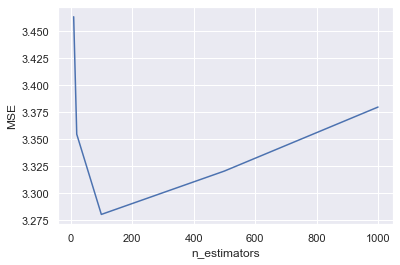

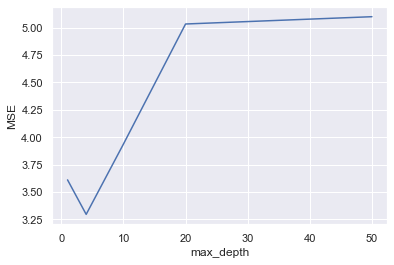

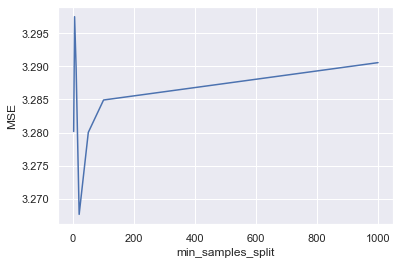

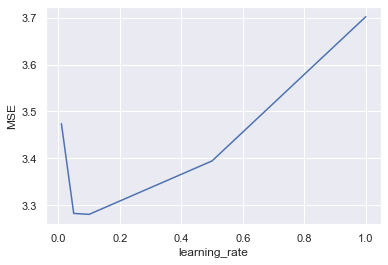

In [88]:
from sklearn.metrics import r2_score, mean_squared_error as MSE

params = {'n_estimators': [10, 20, 100, 500, 1000],
         'max_depth': [1, 4, 10, 20, 50],
         'min_samples_split' : [2, 5, 10, 20, 50, 100, 1000],
         'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1]}

best_params = {}
for p in params:
    fig, ax = plt.subplots(1)
    scores_MSE = []
    vals = []
    min_mse = 100
    for v in params[p]:
        param = {p : v}
        gbm = GBR(**param)
        gbm.fit(X_train, y_train)
        predicted = gbm.predict(X_test)
        vals.append(v)
        mse = MSE(y_test, predicted)
        if min_mse > mse:
            min_mse = mse
            best_params[p] = v
        scores_MSE.append(mse)
    temp = pd.DataFrame({'MSE':scores_MSE, p:vals})
    sns.lineplot(x=p, y="MSE", data=temp, ax=ax)

In [89]:
best_params

{'n_estimators': 100,
 'max_depth': 4,
 'min_samples_split': 20,
 'learning_rate': 0.1}

In [90]:
gbm = GBR(**best_params)
gbm.fit(X_train, y_train)
predicted = gbm.predict(X_test)
score(y_test, predicted, "Градиентный бустинг:")

Градиентный бустинг:
0.23646244561815533
3.2530608588520455


In [82]:
gbm = GBR(n_estimators=100, max_depth=4, min_samples_split=10, learning_rate=0.1)
gbm.fit(X_train, y_train)
predicted = gbm.predict(X_test)
score(y_test, predicted, "Градиентный бустинг:")

Градиентный бустинг:
0.2970782324875436
3.0898292570501016


### Обучение леса решений

In [92]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train, y_train)
predicted = forest.predict(X_test)
score(y_test, predicted, "Лес решений:")

Лес решений:
0.10386166657765816
3.8180080597780766


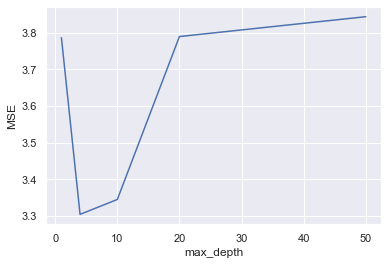

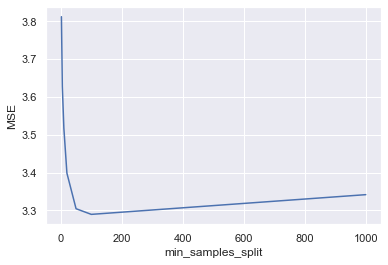

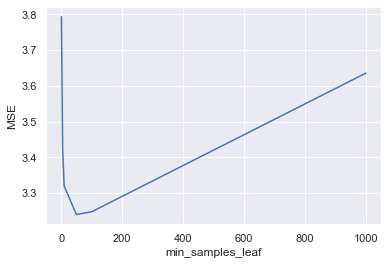

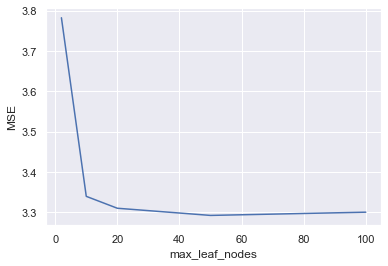

In [97]:
from sklearn.metrics import r2_score, mean_squared_error as MSE

params = {'max_depth': [1, 4, 10, 20, 50],
         'min_samples_split' : [2, 5, 10, 20, 50, 100, 1000],
          'min_samples_leaf' : [1, 5, 10, 50, 100, 1000],
         'max_leaf_nodes' : [2, 10, 20, 50, 100]}

best_params = {}
for p in params:
    fig, ax = plt.subplots(1)
    scores_MSE = []
    vals = []
    min_mse = 100
    for v in params[p]:
        param = {p : v}
        forest = RandomForestRegressor(**param)
        forest.fit(X_train, y_train)
        predicted = forest.predict(X_test)
        vals.append(v)
        mse = MSE(y_test, predicted)
        if min_mse > mse:
            min_mse = mse
            best_params[p] = v
        scores_MSE.append(mse)
    temp = pd.DataFrame({'MSE':scores_MSE, p:vals})
    sns.lineplot(x=p, y="MSE", data=temp, ax=ax)

In [98]:
best_params

{'max_depth': 4,
 'min_samples_split': 100,
 'min_samples_leaf': 50,
 'max_leaf_nodes': 50}

In [99]:
forest = RandomForestRegressor(**best_params)
forest.fit(X_train, y_train)
predicted = forest.predict(X_test)
score(y_test, predicted, "Лес решений:")

Лес решений:
0.22915381972595616
3.2841993466519734


### Обучение SVM

In [99]:
from sklearn.svm import SVR

svm = SVR(C=1.0, epsilon=0.2)
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)
score(y_test, predicted, "SVM:")

C 1
C 1.5
C 3
C 6
C 10
epsilon 0.2
epsilon 0.25
epsilon 0.3
epsilon 0.4
epsilon 0.7
epsilon 0.95


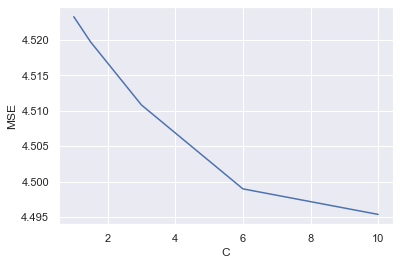

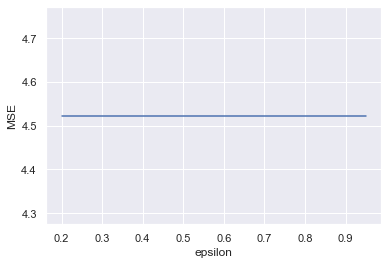

In [112]:
from sklearn.metrics import r2_score, mean_squared_error as MSE

params = {'C': [1, 1.5, 3, 6, 10],
         'epsilon' : [0.2, 0.25, 0.3, 0.4, 0.7, 0.95]}

best_params = {}
for p in params:
    fig, ax = plt.subplots(1)
    scores_MSE = []
    vals = []
    min_mse = 100
    for v in params[p]:
        print(p, v)
        param = {p : v,
                'epsilon' : 0.2}
        svm = SVR(**param)
        svm.fit(X_train, y_train)
        predicted = svm.predict(X_test)
        vals.append(v)
        mse = MSE(y_test, predicted)
        if min_mse > mse:
            min_mse = mse
            best_params[p] = v
        scores_MSE.append(mse)
    temp = pd.DataFrame({'MSE':scores_MSE, p:vals})
    sns.lineplot(x=p, y="MSE", data=temp, ax=ax)

In [113]:
best_params

{'C': 10, 'epsilon': 0.2}

In [114]:
svm = SVR(**best_params)
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)
score(y_test, predicted, "SVM:")

SVM:
0.007127438712367984
4.495344669103504


In [91]:
from sklearn.svm import SVR

svm = SVR(C=10.0, epsilon=0.2, cache_size=1500)
svm.fit(X_train, y_train)
predicted = svm.predict(X_test)
score(y_test, predicted, "SVM:")

SVM:
0.024128686461221016
4.444577765041215


### Кросс-валидация

In [100]:
from sklearn.model_selection import cross_val_score

scores = []
scores.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())
scores.append(cross_val_score(gbm, X, y, cv=5, scoring='r2').mean())
scores.append(cross_val_score(tree, X, y, cv=5, scoring='r2').mean())
#scores.append(cross_val_score(svm, X, y, cv=5, scoring='r2').mean())

### Случайное разбиение

In [101]:
def random_split(X, y, model, N=20):
    scores = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
        
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        score = r2_score(y_test, predicted)
        scores.append(score)
    return scores

In [102]:
scores_random = []
scores_random.append(random_split(X, y, reg))
scores_random.append(random_split(X, y, gbm))
scores_random.append(random_split(X, y, forest))
#scores_random.append(random_split(X, y, svm))

In [103]:
scores_random[0].append(scores[0])
scores_random[1].append(scores[1])
scores_random[2].append(scores[2])
#scores_random[3].append(scores[3])

In [109]:
models = pd.DataFrame({'Линейная регрессия' : scores_random[0], 
                       'Градиентный бустинг' : scores_random[1], 
                       'Лес решений' : scores_random[2]})
                      #'SVM' : scores_random[3]})

In [110]:
models

,Линейная регрессия,Градиентный бустинг,Лес решений
0,0.158784,0.256105,0.255408
1,0.158784,0.256071,0.255174
2,0.158784,0.256105,0.255647
3,0.158784,0.256105,0.255712
4,0.158784,0.256105,0.255355
5,0.158784,0.256105,0.255658
6,0.158784,0.256071,0.255942
7,0.158784,0.256105,0.255426
8,0.158784,0.256071,0.255554
9,0.158784,0.256071,0.256129


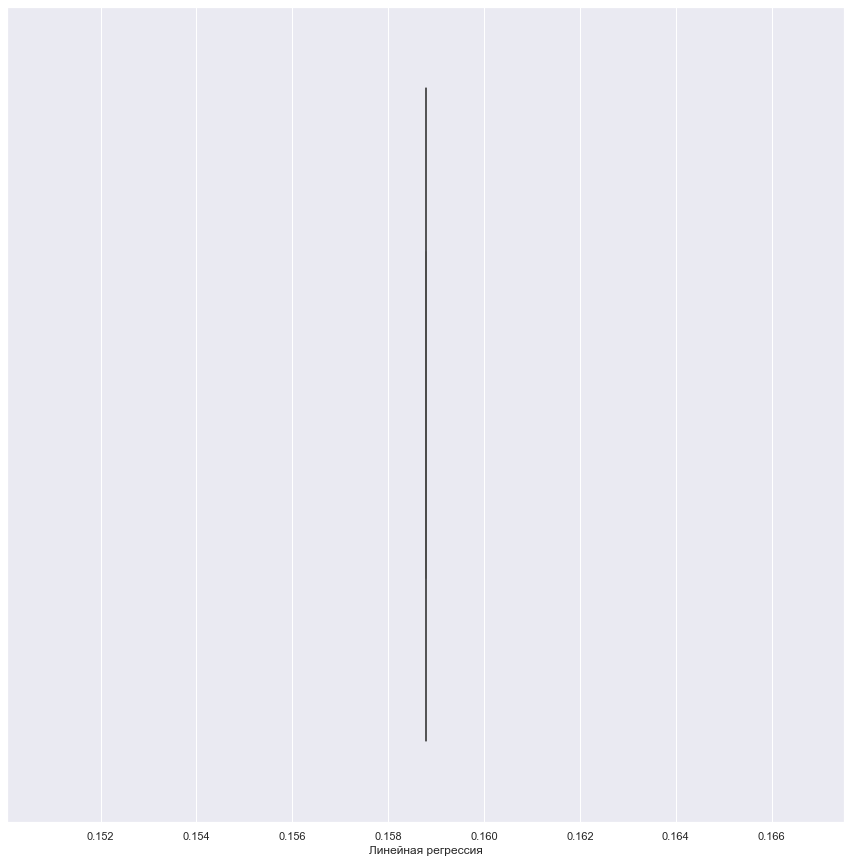

<Figure size 432x288 with 0 Axes>

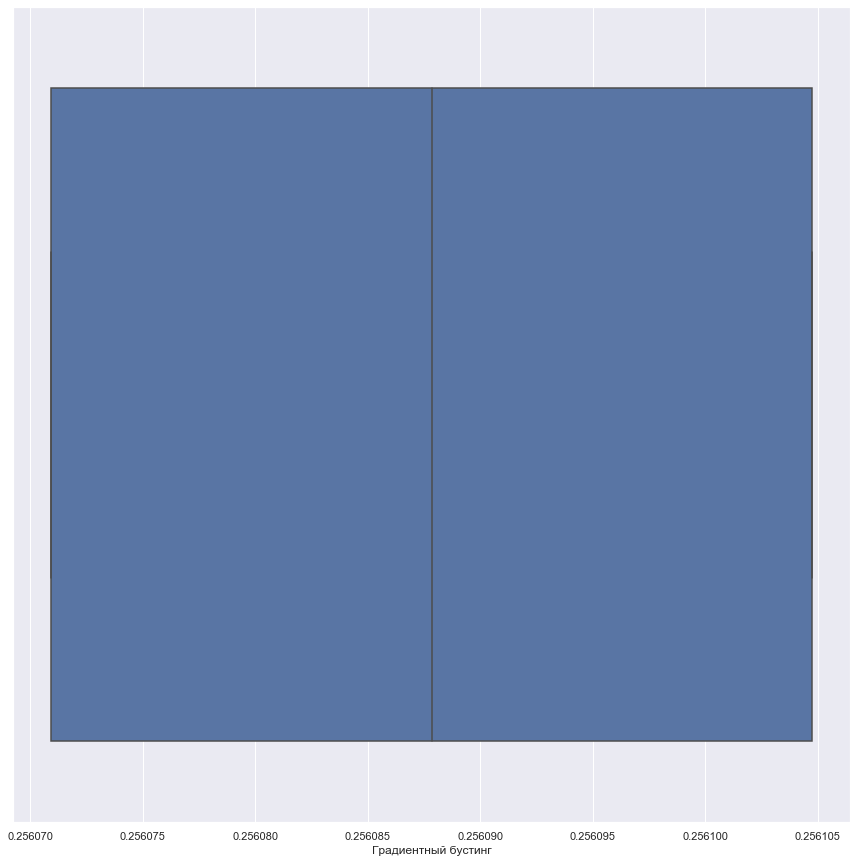

<Figure size 432x288 with 0 Axes>

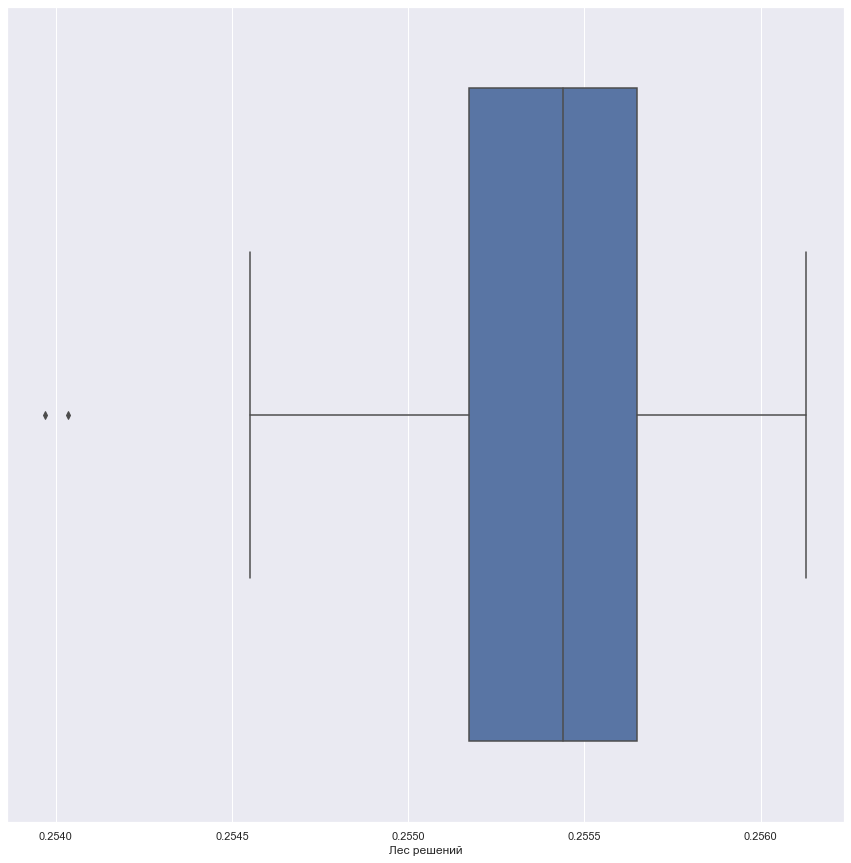

<Figure size 432x288 with 0 Axes>

In [116]:
for c in models.columns:
    fig, ax = plt.subplots(figsize=(15,15))
    sns.set()
    plt.figure()
    sns.boxplot(models[c], ax=ax)

In [108]:
scores_random[0].pop()
scores_random[1].pop()
scores_random[2].pop()

0.10767751301896858